In [1]:
import numpy as np
import cv2 as cv
from mcf.detection import Detector, DetectionStatus
from mcf.data_types import DetectionRegion
from matplotlib import pyplot as plt
from time import time

detector = Detector()

In [2]:
def pre_process(frame):
    if frame is not None:
        frame = cv.GaussianBlur(frame, (7,7), 2) 
        # frame = cv.bilateralFilter(frame, -1,7,7)  
        frame = frame.astype('float')
        # frame = decimate(frame, 2).astype('float64')
    return frame

def plot_motion_block(motion_block):
    Y = []
    X = []
    for y in range(motion_block.shape[0]):
        for x in range(motion_block.shape[1]):
            y_value = motion_block[y,x,0]
            x_value = motion_block[y,x,1]
            if y_value != 0 and x_value != 0:
                Y.append(y_value)
                X.append(x_value)

    plt.figure()
    plt.plot(X, Y, 'o')
    plt.title(f'motion vectors')
    plt.ylabel(f'y-value')
    plt.xlabel(f'x-value')
    plt.grid()
    print(f'mean yx: {np.median(Y)},{np.median(X)}')


def get_search_region(bounding_box, frame_shape, block_size):
    (xl,yl),(xh,yh) = bounding_box
    
    # truncate any blocks that run over image boundaries
    yl = min(max(yl, block_size[0]//2), frame_shape[0]-block_size[0]//2)
    yh = min(max(yh, block_size[0]//2), frame_shape[0]-block_size[0]//2)
    xl = min(max(xl, block_size[1]//2), frame_shape[1]-block_size[1]//2)
    xh = min(max(xh, block_size[1]//2), frame_shape[1]-block_size[1]//2)

    return yl,yh,xl,xh


In [3]:
# Load Sequential Frames from Video
video = cv.VideoCapture(f'/Users/elyons/Documents/dev/repos/motion_compensated_filtering_for_image_recovery/prototype/data/highway.mp4')
for _ in range(150): # advance partway because there is more motion further into the video
    _, frame = video.read()
_, frame_last = video.read()
_, frame_current = video.read()

# get detection regions
_, detection_regions_last = detector.run(frame_last)
_, detection_regions_current = detector.run(frame_current)

gray_current = cv.cvtColor(frame_last, cv.COLOR_BGR2GRAY)
gray_last = cv.cvtColor(frame_current, cv.COLOR_BGR2GRAY)

# frame_last = pre_process(frame_last)
# frame_current = pre_process(frame_current)

# plt.figure(figsize=(10,10))
# plt.imshow(frame_current / np.max(frame_current))

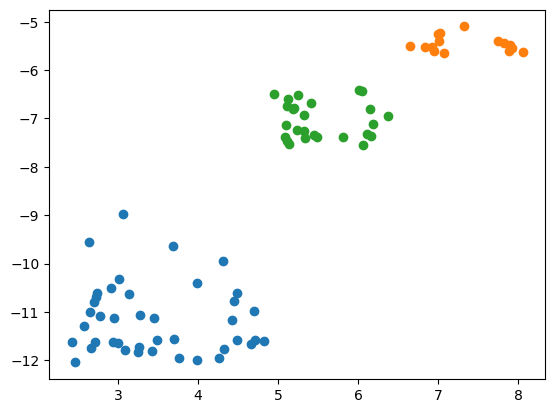

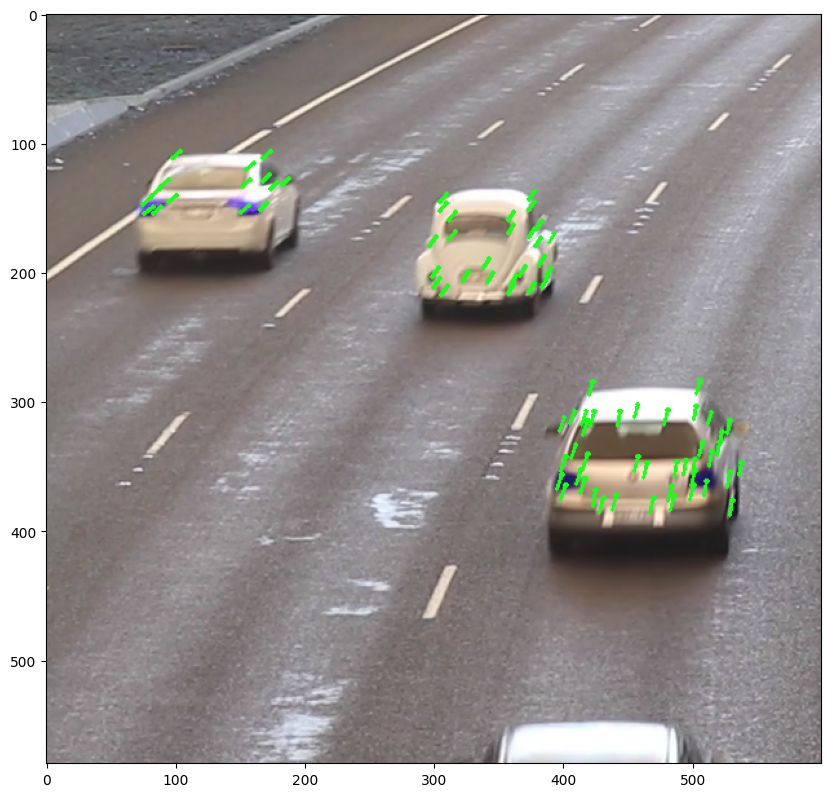

In [45]:
# params for corner detection 
feature_params = dict( maxCorners = 50, 
                       qualityLevel = 0.1, 
                       minDistance = 7, 
                       blockSize = 7 ) 
  
# Parameters for lucas kanade optical flow 
lk_params = dict( winSize = (15, 15), 
                  maxLevel = 2, 
                  criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 
                              10, 0.03)) 

frame_out = frame_current.copy()

for detection_region in detection_regions_current:

    bounding_box = detection_region.bounding_box
    (xl,yl),(xh,yh) = bounding_box
    mask = detection_region.mask
    _mask = np.zeros(gray_current.shape, dtype=np.uint8)
    _mask[yl:yh,xl:xh] = mask
    p0 = cv.goodFeaturesToTrack(gray_last, mask=_mask, **feature_params)

    p1, st, err = cv.calcOpticalFlowPyrLK(gray_current, gray_last, p0, None, **lk_params) 

    # draw the tracks
    # Select good points 
    good_new = p1[st == 1] 
    good_old = p0[st == 1]
  
    for start_point, end_point in zip(p0.squeeze(), p1.squeeze()):
        start = (int(start_point[0]), int(start_point[1]))
        end = (int(end_point[0]), int(end_point[1]))
        frame_out = cv.arrowedLine(frame_out, (start), (end), (25,255,25), 2)

    Y = []
    X = []
    for start_point, end_point in zip(p0.squeeze(), p1.squeeze()):
        X.append(end_point[0] - start_point[0])
        Y.append(end_point[1] - start_point[1])
  
    plt.plot(X,Y,'o')

plt.figure(figsize=(10,10))
plt.imshow(frame_out[500:,750:1350])
    